<a href="https://colab.research.google.com/github/MarshaGomez/DNN-Sketches-image-analysis/blob/main/Code/Pca_Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import time
import itertools
import os, shutil
import tensorflow as tf
import matplotlib.pyplot as plt

from random import random
from ipywidgets import Image
from numpy.linalg import norm
from IPython.display import display
from keras.models import Model
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint

# tensorflow version 2.4.0
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

In [ ]:
zip_path = '/content/gdrive/Shareddrives/COMPUTER_VISION/MIM_zipped.zip'
!cp "{zip_path}" .
!unzip -q MIM_zipped.zip
!rm MIM_zipped.zip

In [ ]:
#data loading
# reading from unzipped
BASE_DIR = "/content/content/gdrive/Shareddrives/COMPUTER_VISION/MIRCV"
# FILELIST_PATH = BASE_DIR + "/filelist.txt"
SKETCHES_DIR = os.path.join(BASE_DIR, "sketches")
MIRFLICKR_DIR = os.path.join(BASE_DIR, "mirflickr/mirflickr25k")

#print(FILELIST_PATH)

#num_folders = os.listdir(SKETCHES_DIR)
#print(num_folders)

In [ ]:
print(os.listdir(os.path.join(SKETCHES_DIR, "png")))
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
      
copytree(f'{SKETCHES_DIR}/png', f'{SKETCHES_DIR}/all')

['rooster', 'head-phones', 'door handle', 'flashlight', 'panda', 'bottle opener', 'revolver', 'binoculars', 'piano', 'lightbulb', 'saxophone', 'snowboard', 'giraffe', 'filelist.txt', 'scissors', 'rabbit', 'pear', 'ship', 'helicopter', 'van', 'barn', 'tiger', 'dragon', 'ice-cream-cone', 'wheel', 'dolphin', 'cell phone', 'tree', 'squirrel', 'speed-boat', 'wheelbarrow', 'screwdriver', 'rifle', 'arm', 'bee', 'house', 'penguin', 'blimp', 'pretzel', 'motorbike', 'mosquito', 'hourglass', 'moon', 'spoon', 'pig', 'pizza', 'rollerblades', 'ant', 'cabinet', 'car (sedan)', 'book', 'bed', 'sailboat', 'candle', 'tooth', 'train', 'strawberry', 'palm tree', 'streetlight', 'present', 'angel', 'envelope', 'table', 'eye', 'bathtub', 'lion', 'fan', 'crocodile', 'castle', 'keyboard', 'crown', 'flying bird', 'human-skeleton', 'octopus', 'laptop', 'nose', 'parrot', 'umbrella', 'bookshelf', 'sponge bob', 'satellite', 'couch', 'bicycle', 'stapler', 'kangaroo', 'door', 'ear', 'mug', 'hot-dog', 'suv', 'fish', 'k

In [ ]:
test_images_per_class = 20 # le immagini sono al massimo 80
try:
  os.rename(f'{SKETCHES_DIR}/png', f'{SKETCHES_DIR}/train')
except:
  print('already renamed')

if not os.path.exists(f'{SKETCHES_DIR}/test'):
  os.mkdir(f'{SKETCHES_DIR}/test')
  for class_folder in os.listdir(f'{SKETCHES_DIR}/train'):
    if os.path.isdir(f'{SKETCHES_DIR}/train/{class_folder}'):
      images = os.listdir(f'{SKETCHES_DIR}/train/{class_folder}')
      os.mkdir(f'{SKETCHES_DIR}/test/{class_folder}')
      for i in range(test_images_per_class):
        os.rename(f'{SKETCHES_DIR}/train/{class_folder}/{images[i]}', f'{SKETCHES_DIR}/test/{class_folder}/{images[i]}')


##Load Data

In [ ]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
BATCH_SIZE = 64

#images normalization 
sketches_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
mirflickr_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

sketches_generator = sketches_datagen.flow_from_directory(
        # This is the target directory
        SKETCHES_DIR + '/all',
        shuffle=False,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)

mirflickr_generator = mirflickr_datagen.flow_from_directory(
        # This is the target directory
        MIRFLICKR_DIR,
        shuffle=False,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)


# unique, counts = np.unique(sketches_generator.classes, return_counts=True)
# labels_dict = dict(zip(unique, counts))
# print(labels_dict)

Found 20000 images belonging to 250 classes.
Found 25000 images belonging to 1 classes.


In [ ]:
def extract_features(extractor, generator, sample_count, dim=2048):
  features = np.zeros((sample_count, dim)) #extractor output shape 
  i = 0
  for inputs_batch, labels_batch in generator:
    start = time.time()
    features_batch = extractor.predict(inputs_batch)
    start = time.time()
    if (i + 1) * BATCH_SIZE > sample_count:
      features[i * BATCH_SIZE : sample_count , :] = features_batch
      assert np.array_equal(np.argmax(labels_batch, axis = 1), generator.labels[i * BATCH_SIZE : sample_count]), 'LABELS NOT CORRESPONDING REINIZIALIZE GENERATOR'
    else:
      features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, : ] = features_batch
      assert np.array_equal(np.argmax(labels_batch, axis = 1), generator.labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]), 'LABELS NOT CORRESPONDING REINIZIALIZE GENERATOR'
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
  
  return features

In [ ]:
def average_precision(requested_label, result_labels, n_ground_truth = 80):
  """
  label ricercata, label ottenute, il numero di oggetti che ci sono quella label
  """
  correct_array = (requested_label == result_labels).astype(int)
  precision_array = [np.mean(correct_array[:k]) for k in range(1, correct_array.shape[0] + 1)]
  # print(precision_array * correct_array) # mi rimangono solo quelli a 1
  return np.sum(precision_array * correct_array) / n_ground_truth

In [ ]:
def mAP(index, features, n_queries = 250, n_labels = 250, img_per_labels = 80, mode = 'euclidean'):
  sum = 0
  for i in range(n_queries):
    label = i % n_labels
    image_idx = ((i * img_per_labels) + int(random() * img_per_labels)) % (n_labels * img_per_labels)
    # print('QUERY')
    # print('index = ' + str(image_idx))
    # print('label =' + str(label))
    res = index.query(features[image_idx], img_per_labels, mode = mode)
    # print('first label of resultset (must be equal to label) = ' + str(res['labels'][0]))
    assert res['labels'][0] == label, 'deve essere della stessa label'
    a = average_precision(label, res['labels'], img_per_labels)
    sum += a
  return sum / n_queries

##LOAD the model you want to extract

In [ ]:
MODEL_PATH = "/content/gdrive/Shareddrives/COMPUTER_VISION/models"

In [ ]:
loaded = models.load_model(os.path.join("/content/gdrive/Shareddrives/COMPUTER_VISION/models_matt", 'inception_finetuning_classification_dense_only_4096_with_dropout.h5'))

finetuned_extactor = Model(loaded.input, loaded.layers[-2].output)
finetuned_extactor.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, None, None, 3 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, None, None, 3 0           batch_normalization_376[0][0]    
______________________________________________________________________________________________

In [ ]:
sketches_features_finetuned = extract_features(finetuned_extactor, sketches_generator, 20000, dim=4096)
mirflickr_features_finetuned = extract_features(finetuned_extactor, mirflickr_generator, 25000, dim=4096)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4096] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


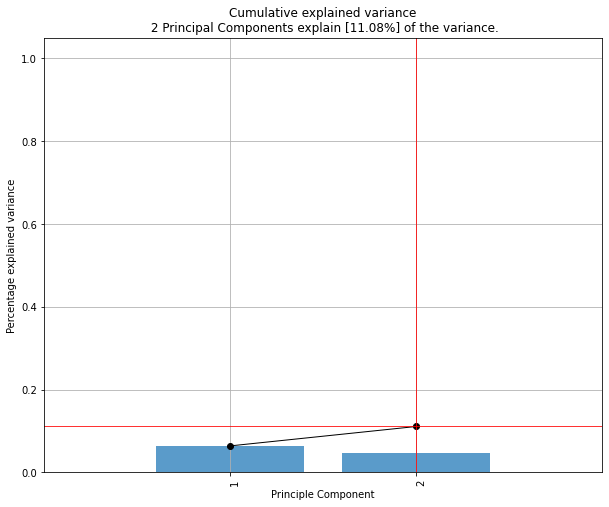

<Figure size 432x288 with 0 Axes>

In [ ]:
!pip install pca

from pca import pca

# Initialize to reduce the data up to the number of componentes that explains 95% of the variance.
model = pca(n_components=0.75)

# Or reduce the data towards 2 PCs
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(sketches_features_finetuned)

# Plot explained variance
fig, ax = model.plot()

[120.06963208  90.08653971]
(2,)
(20000, 4096)
(20000, 2)


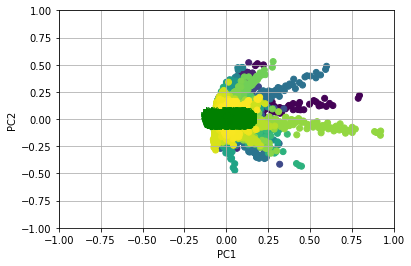

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler



y = sketches_generator.labels

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(sketches_features_finetuned)
X=scaler.transform(sketches_features_finetuned)    
pca = PCA(2)

x_new = pca.fit_transform(X)

#x_new = pca.explained_variance_
print(pca.explained_variance_)
print(pca.explained_variance_.shape)
print(X.shape)
print(x_new.shape)
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))  # ---- original
#myplot(x_new[:],np.transpose(pca.components_[0:2, :]))
plt.show()

In [ ]:
from sklearn.decomposition import PCA
# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(sketches_features_finetuned)
x=scaler.transform(sketches_features_finetuned)  
y = sketches_generator.labels
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

lab = pd.DataFrame( data = y, columns = ['label'])


  
pca = PCA()
finalDf = pd.concat([principalDf, lab], axis=1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

for target, color in zip(y,x):
    indicesToKeep = finalDf['label'] == y
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               ,  s = 50)
ax.legend(targets)
ax.grid()
